In [1]:
if 'google.colab' in str(get_ipython()):
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.3.1 tensorflow-quantum
    !rm -rf quantum-gans
    !git clone https://github.com/WiktorJ/quantum-gans
    !cd quantum-gans; pip install .
    neptun_token = None # put manually for the time being
else:
    import subprocess
    def get_var(varname):
        CMD = 'echo $(source ~/.bash_profile; echo $%s)' % varname
        p = subprocess.Popen(CMD, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
        return p.stdout.readlines()[0].strip()
    neptun_token = get_var('NEPTUNE_API_TOKEN').decode("utf-8") 

In [2]:
%load_ext autoreload
%autoreload 2

In [61]:
import io
import math
import json
import neptune
import tensorflow as tf

import cirq
import numpy as np
from qsgenerator.utils import map_to_radians
from qsgenerator.qugans import circuits
from qsgenerator.resolvers import resolve_all
from qsgenerator.qugans.training import Trainer
from qsgenerator.phase.circuits import build_ground_state_circuit
from qsgenerator.phase.constants import z1_theta, z2_theta
from qsgenerator.phase.analitical import  get_ground_state_for_g
from qsgenerator.states.simple_state_circuits import build_x_rotation_state
from qsgenerator.states.simple_rotation_generators import get_binary_x_rotation_provider, get_arcsin_x_rotation_provider
from qsgenerator.phase.analitical import construct_hamiltonian, get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator

In [62]:
generator_layers = 5
discriminator_layers = 5
data_bus_size = 5

In [63]:
real_phase = True
generic_generator = False
all_layers_labeling = False
full_layer_labeling = False
use_gen_label_qubit = False
use_disc_label_qubit = False
zxz = True
fixed_gates = {"z1": z1_theta, "z2": z2_theta}

In [64]:
gen, gs, disc, ds, ls, data_qubits, out_qubit = circuits.build_gan_circuits(
    generator_layers, 
    discriminator_layers, 
    data_bus_size, 
    all_layers_labeling=all_layers_labeling,
    full_layer_labeling=full_layer_labeling,
    use_gen_label_qubit=use_gen_label_qubit,
    use_disc_label_qubit=use_disc_label_qubit)

In [65]:
if not generic_generator:
    gen, gs, symbols_dict_gen = build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)
else:
    symbols_dict_gen = {}

In [66]:
gen, gs = resolve_all(gen, gs, symbols_dict_gen, fixed_gates)

In [67]:
if real_phase:
    real, real_symbols, symbols_dict_real = build_ground_state_circuit(qubits=data_qubits)
else:
    real, real_symbols, symbols_dict_real = build_x_rotation_state(qubits=data_qubits)

In [68]:
pure_gen = gen.copy()
gen.append([disc])

In [69]:
pure_real = real.copy()
real.append([disc])

In [70]:
print("REAL GROUND STATE")
pure_real

REAL GROUND STATE


(0, 1): ───H───@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │
(0, 2): ───────X───Z───Ry(theta_r)───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                   │                                       │
(0, 3): ─────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                   │                                       │
(0, 4): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                                   │                                       │
(0, 5): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───

In [71]:
print("GENERATOR")
pure_gen

GENERATOR


(0, 1): ───H───@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │
(0, 2): ───────X───Z───Rz(1.5π)───Rx(0.318309886183791*pi*theta1)───Rz(-1.5π)───X─────────────────────────────────────────────────────────@───X──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@───X────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                          │                                                                                                                              │
(0, 3): ────────────────────────────────────────────────────────────────────────Rz(1.5π)───Rx(0.318309886183791*pi*theta10)───Rz(-1.5π)───X───X───Rz(1.5π)───Rx(0.318309886183791*pi*theta13)───Rz(-1.5π)───X───Rz(1.5π)───Rx(0.318309886183791*pi*theta4)───Rz(-1.5π)───X───X───Rz(1.5π)───Rx(0.318309886183791*pi*theta7)───Rz(-1.5π)───X───X─────────────────────────────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                                                                                                                                                                        │                                                                                                                               │
(0, 4): ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rz(1.5π)───Rx(0.318309886183791*pi*theta22)───Rz(-1.5π)───X───X───Rz(1.5π)───Rx(0.318309886183791*pi*theta25)───Rz(-1.5π)───X───Rz(1.5π)───Rx(0.318309886183791*pi*theta16)───Rz(-1.5π)───X───X───Rz(1.5π)───Rx(0.318309886183791*pi*theta19)───Rz(-1.5π)───X───X─────────────────────────────────────────────────────────@───X

In [72]:
print("DISCRIMINATOR")
disc

DISCRIMINATOR


(0, 0): ───Rx(d0)───Rz(d6)────ZZ────────────────Rx(d17)───Rz(d23)───ZZ────────────────Rx(d34)───Rz(d40)───ZZ────────────────Rx(d51)───Rz(d57)───ZZ────────────────Rx(d68)───Rz(d74)───ZZ────────────────
                              │                                     │                                     │                                     │                                     │
(0, 1): ───Rx(d1)───Rz(d7)────ZZ^d12───ZZ───────Rx(d18)───Rz(d24)───ZZ^d29───ZZ───────Rx(d35)───Rz(d41)───ZZ^d46───ZZ───────Rx(d52)───Rz(d58)───ZZ^d63───ZZ───────Rx(d69)───Rz(d75)───ZZ^d80───ZZ───────
                                       │                                     │                                     │                                     │                                     │
(0, 2): ───Rx(d2)───Rz(d8)────ZZ───────ZZ^d15───Rx(d19)───Rz(d25)───ZZ───────ZZ^d32───Rx(d36)───Rz(d42)───ZZ───────ZZ^d49───Rx(d53)───Rz(d59)───ZZ───────ZZ^d66───Rx(d70)───Rz(d76)───ZZ───────ZZ^d83───
                              │                                     │                                     │                                     │                                     │
(0, 3): ───Rx(d3)───Rz(d9)────ZZ^d13───ZZ───────Rx(d20)───Rz(d26)───ZZ^d30───ZZ───────Rx(d37)───Rz(d43)───ZZ^d47───ZZ───────Rx(d54)───Rz(d60)───ZZ^d64───ZZ───────Rx(d71)───Rz(d77)───ZZ^d81───ZZ───────
                                       │                                     │                                     │                                     │                                     │
(0, 4): ───Rx(d4)───Rz(d10)───ZZ───────ZZ^d16───Rx(d21)───Rz(d27)───ZZ───────ZZ^d33───Rx(d38)───Rz(d44)───ZZ───────ZZ^d50───Rx(d55)───Rz(d61)───ZZ───────ZZ^d67───Rx(d72)───Rz(d78)───ZZ───────ZZ^d84───
                              │                                     │                                     │                                     │                                     │
(0, 5): ───Rx(d5)───Rz(d11)───ZZ^d14────────────Rx(d22)───Rz(d28)───ZZ^d31────────────Rx(d39)───Rz(d45)───ZZ^d48────────────Rx(d56)───Rz(d62)───ZZ^d65────────────Rx(d73)───Rz(d79)───ZZ^d82────────────

In [73]:
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([0] * len(gs)) + \
                   np.random.normal(scale=eps, size=(len(gs),))
init_disc_weights = np.random.normal(size=(len(ds),))

gen_weights = tf.Variable(init_gen_weights, dtype=tf.float32)
disc_weights = tf.Variable(init_disc_weights, dtype=tf.float32)

In [74]:
class CustomScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps=4000):
        super(CustomScheduler, self).__init__()
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        return max(math.e ** - ((step+200) / (self.warmup_steps / math.log(100))), 0.01)

In [75]:
learning_rate = CustomScheduler()

opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [76]:
#g_values = [0.1, 0.4, 0.25]
g_values = [-0.5]
# x_rotations = get_binary_x_rotation_provider({0: '100', 1: '011', 2: '101'})
# real_values_provider = get_arcsin_x_rotation_provider(g_values, data_bus_size)
real_values_provider = get_g_parameters_provider()

In [77]:
epochs = 1
disc_iteration = 20
gen_iteration = 5

In [78]:
neptune.init(project_qualified_name='wiktor.jurasz/thesis', api_token=neptun_token)
neptun_params = {
    'g_values': g_values,
    'size':  data_bus_size,
    'real_phase': real_phase,
    'generic_generator': generic_generator,
    'all_layers_labeling': all_layers_labeling,
    'full_layer_labeling': full_layer_labeling,
    'use_gen_label_qubit': use_gen_label_qubit,
    'use_disc_label_qubit': use_disc_label_qubit,
    'zxz': zxz,
    'fixed_gates': fixed_gates,
    'disc_iteration': disc_iteration,
    'gen_iteration': gen_iteration
}
neptune.create_experiment(name=None, description=None, params=neptun_params)
neptune.log_artifact(io.StringIO(str(disc)), "disc.txt")
neptune.log_artifact(io.StringIO(str(gen)), "gen.txt")

psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/wiktor.jurasz/thesis/e/THES-9


In [79]:
trainer = Trainer(g_values, 
                  data_bus_size, 
                  disc, 
                  gen, 
                  real, 
                  out_qubit, 
                  ds, 
                  gs, 
                  real_symbols, 
                  ls,
                  real_values_provider = real_values_provider,
                  use_analytical_expectation=True,
                  use_neptune=True)

<Figure size 432x288 with 0 Axes>

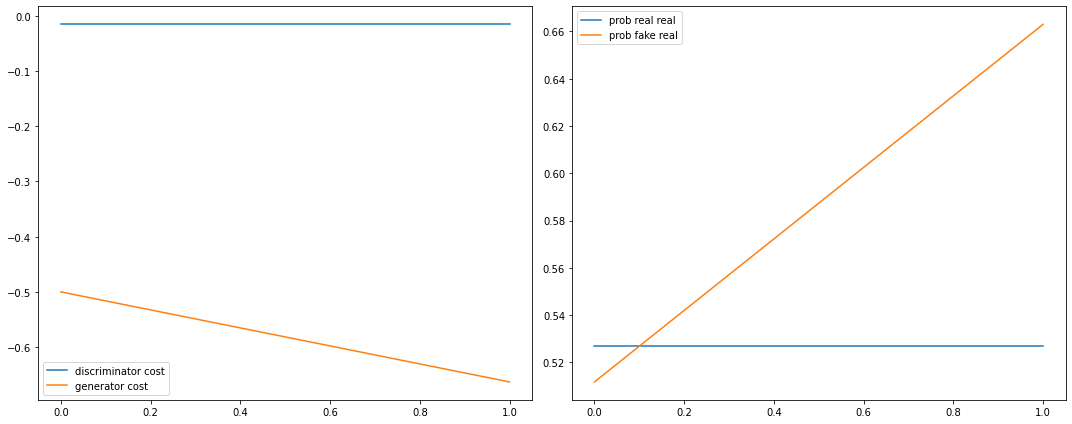

----------- AFTER GENERATOR TRAINING -----------
Epoch 0: generator cost = -0.6630381345748901
Epoch 0: discriminator cost = -0.01523900032043457
Prob(fake classified as real):  0.66303813
Prob(real classified as real):  0.5269769
-------------------------------------
----------- TRAINING DONE -----------


In [80]:
snapshot_interval_epochs = 20
results, json_result = trainer.train(disc_weights,
      gen_weights, 
      opt, 
      epochs=epochs, 
      disc_iteration=disc_iteration, 
      gen_iteration=gen_iteration,
      snapshot_interval_epochs=snapshot_interval_epochs)
res_dict = trainer.get_params_and_results()

In [84]:
gen_evaluator = CircuitEvaluator(pure_gen, gs, trainer.label_value_provider)
disc_evaluator = CircuitEvaluator(disc, ds, None)
real_evaluator = CircuitEvaluator(pure_real, real_symbols, trainer.real_values_provider)

In [85]:
neptune.log_artifact(io.StringIO(disc_evaluator.get_resolved_circuit(res_dict['weights'][-1]['disc_weights'].tolist()).to_qasm()), 'desc_qasm.txt')
neptune.log_artifact(io.StringIO(gen_evaluator.get_resolved_circuit(res_dict['weights'][-1]['gen_weights'].tolist()).to_qasm()), 'gen_qasm.txt')
neptune.log_artifact(io.StringIO(json_result), 'weights.json')

In [ ]:
def get_gen_for_g(g, gen_weights, gen_provider):
    rad = gen_provider(g)
    return np.append(gen_weights, rad)

def get_states_and_fidelty_for_real(gen_evaluator, 
                                    real_evaluator, 
                                    gen_weights, 
                                    g, 
                                    sized):
    generated = gen_evaluator.get_state_from_params(get_gen_for_g(g, gen_weights, gen_evaluator.label_value_provider))
    real = real_evaluator.get_state_from_params(real_evaluator.label_value_provider(g))
    return generated, real, cirq.fidelity(generated, real)

def get_states_and_fidelty_for_ground(gen_evaluator, g, gen_weights, size):

    generated = gen_evaluator.get_state_from_params(get_gen_for_g(g, gen_weights, gen_evaluator.label_value_provider), list(range(size)))
    ground = get_ground_state_for_g(g, size)
    return generated, ground, cirq.fidelity(generated, ground)

def compare_generated_for_g(gen_evaluator, g1, g2, gen_weights, size):
    generated1 = gen_evaluator.get_state_from_params(get_gen_for_g(g1, gen_weights, gen_evaluator.label_value_provider), list(range(size)))
    generated2 = gen_evaluator.get_state_from_params(get_gen_for_g(g2, gen_weights, gen_evaluator.label_value_provider), list(range(size)))
    return generated1, generated2, cirq.fidelity(generated1, generated2)

In [ ]:
trained_disc_weights = tf.Variable(np.array([ 1.25888796e+01,  1.10409822e+01,  1.27487049e+01,  1.32927475e+01,
       -3.20522385e+01,  2.98508596e+00, -7.54223883e-01,  8.97036648e+00,
        8.98472309e+00, -2.77423954e+00,  8.90891266e+00,  5.72837019e+00,
        6.03105211e+00, -4.64482594e+00, -1.10843427e-01,  7.78598115e-02,
        3.00343895e+00,  3.83781940e-01,  6.08641243e+00,  8.64131927e+00,
       -2.17593918e+01,  1.45857897e+01,  2.36893883e+01,  8.75363445e+00,
       -2.42768993e+01,  1.27688437e+01,  2.53628349e+00,  1.39768391e+01,
        1.40961084e+01, -2.04474068e+01,  4.71392822e+00,  1.66926212e+01,
        1.88311214e+01,  9.17525005e+00,  1.16109962e+01,  1.08004580e+01,
        1.10795708e+01,  5.81477690e+00, -5.50215101e+00,  2.22007637e+01,
        2.25015125e+01,  3.21826210e+01, -1.80058708e+01, -7.85126591e+00,
       -7.77073908e+00,  1.40237570e+01,  3.14071465e+01, -1.07477732e+01,
        1.55852342e+00,  2.63786411e+01,  1.31890945e+01,  7.14759350e+00,
        5.46145630e+00, -1.79730053e+01,  7.40563774e+00,  1.06135674e+01,
       -1.55095673e+00, -2.66580944e+01,  6.51995277e+00, -2.37151980e+00,
        3.51896515e+01,  1.50027342e+01,  1.80733763e-02, -1.75052185e+01,
        9.60706902e+00, -6.06413984e+00,  5.35433817e+00, -7.88707399e+00,
        1.27363043e+01,  1.02446747e+01]), dtype=tf.float32)

trained_gen_weights =[
      7.905319690704346,
      -1.8633191585540771,
      -4.245143413543701,
      -0.46167176961898804,
      -0.9651000499725342,
      2.140392541885376,
      -5.569220066070557,
      -4.626476287841797,
      0.050108544528484344,
      -9.636614799499512,
      0.7460542917251587,
      7.176821708679199,
      -3.124521255493164,
      2.7807815074920654,
      0.46627435088157654,
      -0.760291337966919,
      5.282293319702148,
      -4.029909610748291,
      3.353888988494873,
      0.7900710105895996,
      -0.4087430536746979,
      -6.351171970367432,
      -2.659658908843994,
      -2.085594654083252,
      -11.018178939819336,
      -13.472908020019531,
      0.0797867700457573,
      -4.080026149749756,
      -4.763267993927002,
      1.5418087244033813,
      7.7455620765686035,
      -6.144144058227539,
      -9.431268692016602,
      -0.511724054813385,
      5.689932823181152,
      7.294072151184082,
      -3.128417491912842,
      5.949368953704834,
      0.8139113187789917
    ]
gen_symbols = gs 
# gen_symbols = gs
# real_symbols = ('r0', 'r1', 'r2')

In [ ]:
def angle_dist(g, phase_angles_provider, weights):
    angles = phase_angles_provider(g)
    z1_rad = 3 * math.pi / 2
    z2_rad = -3 * math.pi / 2
    z1_deg = math.degrees(z1_rad)
    z2_deg = math.degrees(z2_rad)
    
    xr_rad = angles[0]
    xv_rad = angles[1]
    xw_rad = angles[2]
    xr_deg = math.degrees(xr_rad)
    xv_deg = math.degrees(xv_rad)
    xw_deg = math.degrees(xw_rad)
    
    
    norm_w_deg = [math.degrees(w) for w in weights]
    deg_diff = [norm_w_deg[0], z1_deg, norm_w_deg[0] - z1_deg, weights[0], z1_rad]
    
    print(z1_deg,z2_deg,xr_deg,xv_deg,xw_deg)
    return deg_diff
    
angle_dist(-0.5, get_g_parameters_provider(), trained_gen_weights04)

In [ ]:
g = -0.5
generated_state, real_state, fidelity = get_states_and_fidelty_for_real(gen_evaluator, real_evaluator, trained_gen_weights, g, data_bus_size)

In [ ]:
g = -0.5
generated_state, real_state, fidelity = get_states_and_fidelty_for_real(gen_evaluator, real_evaluator, trained_gen_weights, g, data_bus_size)

In [ ]:
generated_state, real_state, fidelity

In [ ]:
neptune.log_artifact(io.StringIO(str({"generated_state": generated_state.tolist(), "real_state": real_state.tolist()})), f"states_g={g}.txt")
neptune.log_metric(f"g={g} fidelity", fidelity)

In [ ]:
trained_gen_weights025 = [(abs(el1) + abs(el2))/2 for el1,el2 in zip(trained_gen_weights04,trained_gen_weights01)]

In [ ]:
get_g_parameters_provider()(g)

In [ ]:
trained_gen_weights025

In [ ]:
generated = gen_evaluator.get_state_from_params(get_gen_for_g(0.25, trained_gen_weights025, real_values_provider))
real = real_evaluator.get_state_from_params(real_values_provider(0.25))
generated, real, cirq.fidelity(generated, real)

In [ ]:
real025 = real_evaluator.get_state_from_params(real_values_provider(0.25))

In [ ]:
real04 = real_evaluator.get_state_from_params(real_values_provider(0.4))
real01 = real_evaluator.get_state_from_params(real_values_provider(0.1))

In [ ]:
cirq.fidelity(real025, -real025)

In [ ]:
compare_generated_for_g(gen_evaluator, -0.9, -0.8, trained_gen_weights, data_bus_size)

In [ ]:
g = 0
get_states_and_fidelty_for_ground(gen_evaluator, g, trained_gen_weights, data_bus_size)